In [1]:
import sys
import torch

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import trange
from sklearn.manifold import TSNE
from geoopt import linalg

sys.path.append("../lib/data")
from get_data import get_data, get_cov

sys.path.append("../lib/spdnet")
import nn as nn_spd
from optimizers import MixOptimizer

sys.path.append("../lib")
from swspd import sliced_wasserstein_spd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

### Data

In [3]:
subject = 1
Xs, ys = get_data(subject, True, "../dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(subject, False, "../dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1

In [4]:
print(Xs.shape, cov_Xs.shape, Xt.shape, cov_Xt.shape)

(273, 22, 1750) torch.Size([273, 1, 1, 22, 22]) (281, 22, 1750) torch.Size([281, 1, 1, 22, 22])


### NNs

In [5]:
class SPDNet(nn.Module):
    def __init__(self, d):
        super().__init__()
        dim = d
        dim1 = d
        dim2 = d
        dim3 = d
#         dim1=200; dim2=100; dim3=50
                
        self.re = nn_spd.ReEig()
        self.bimap1 = nn_spd.BiMap(1,1,dim,dim1)
        self.batchnorm1 = nn_spd.BatchNormSPD(dim1)
        self.bimap2 = nn_spd.BiMap(1,1,dim1,dim2)
        self.batchnorm2 = nn_spd.BatchNormSPD(dim2)
        self.bimap3 = nn_spd.BiMap(1,1,dim2,dim3)
        self.batchnorm3 = nn_spd.BatchNormSPD(dim3)
#         self.logeig = nn_spd.LogEig() ## projection on Symmetric matrices

#         self.linear=nn.Linear(dim3**2,classes).double()
        
    def forward(self,x):
#         print(x.device)
        x_spd = self.re(self.batchnorm1(self.bimap1(x)))
#         print("0", torch.any(torch.linalg.eigh(x_spd)[0]<0))
        x_spd = self.re(self.batchnorm2(self.bimap2(x_spd)))
#         print("1", torch.any(torch.linalg.eigh(x_spd)[0]<0))
        x_spd = self.batchnorm3(self.bimap3(x_spd))
#         print("2", torch.any(torch.linalg.eigh(x_spd)[0]<0))

#         x_vec = self.logeig(x_spd) #.view(x_spd.shape[0],-1)
#         y = self.linear(x_vec)
#         print("x_vec", torch.any(torch.linalg.eigh(x_vec)[0]<0))

        return x_spd

In [6]:
model = SPDNet(22).to(device)

In [7]:
print(model)

SPDNet(
  (re): ReEig()
  (bimap1): BiMap()
  (batchnorm1): BatchNormSPD()
  (bimap2): BiMap()
  (batchnorm2): BatchNormSPD()
  (bimap3): BiMap()
  (batchnorm3): BatchNormSPD()
)


In [8]:
out = model(torch.tensor(cov_Xs)[:,:,0])
out.shape

/tmp/ipykernel_3473975/2873263099.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(cov_Xs)[:,:,0])
/share/castor/home/bonet/SPD/SW_SPD/DA/../lib/spdnet/functional.py:68: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811757271/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2894.)
  s, U[i,j] = th.eig(P[i,j],True)


torch.Size([273, 1, 22, 22])

In [9]:
torch.tensor(cov_Xs)[:,:,0].shape

/tmp/ipykernel_3473975/4122971973.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(cov_Xs)[:,:,0].shape


torch.Size([273, 1, 22, 22])

In [11]:
class mlp_spd(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
#         self.layers = nn.ModuleList()
#         self.layers.append(nn.Linear(d_in,nh))
#         for i in range(n_layers):
#             self.layers.append(nn.Linear(nh,nh))
#         self.layers.append(nn.Linear(nh,d_out))

        self.dense1 = nn.Linear(d_in, 500)
        self.dense2 = nn.Linear(500, 200)
        self.dense3 = nn.Linear(200,100)
        self.dense4 = nn.Linear(100, d_out)
        self.logeig = nn_spd.LogEig() ## projection on Symmetric matrices


    def forward(self, x_spd):
        x = self.logeig(x_spd).view(x_spd.shape[0], -1)
        
#         for layer in self.layers:
#             x = F.leaky_relu(layer(x),0.2)

        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.relu(self.dense3(x))
        x = F.relu(self.dense4(x))
            
        return F.softmax(x, dim=-1)

### Baseline: Classifier on source

In [12]:
epochs = 2500
num_projs = 500
d = 22
n_classes = 4
lr = 1e-3

freq = 0

criterion = nn.CrossEntropyLoss()

classifier = mlp_spd(d*d, 3, n_classes, 5).to(device)

# optimizer = MixOptimizer(list(classifier.parameters()), lr=lr, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)

L_loss = []
L_acc = []

pbar = trange(epochs)

for e in pbar:    
    y_hat = classifier(cov_Xs[:,:,freq].type(torch.float32))
    classif_loss = criterion(y_hat, ys)
    
    loss = classif_loss
    loss.backward()
    
    L_loss.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
#     pbar.set_postfix_str(f"loss = {loss.item():.3f} ")
#     print(loss.item(), align_loss.item(), classif_loss.item())

    with torch.no_grad():
        y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        
        L_acc.append(acc.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"acc = {acc.item():.3f}")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [03:21<00:00, 12.42it/s, loss = 0.796 acc = 66.904]


In [13]:
y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 66.90391540527344%


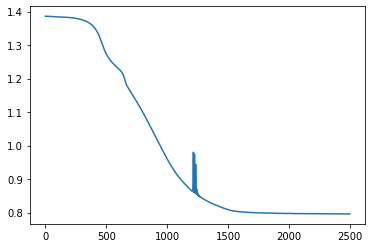

In [14]:
plt.plot(L_loss)
plt.show()

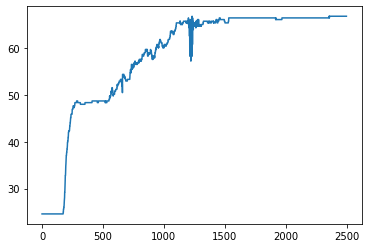

In [15]:
plt.plot(L_acc)
plt.show()

In [16]:
log_Xs = linalg.sym_logm(cov_Xs[:,:,freq].detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,:,freq].detach().cpu()).reshape(-1, d*d)

In [17]:
data = torch.cat([log_Xs, log_Xt], dim=0)

In [18]:
X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(data.numpy())

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


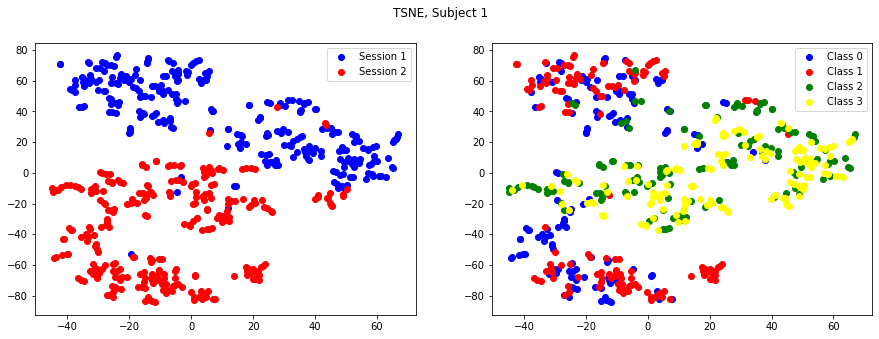

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

ax[0].legend()
ax[1].legend()

plt.suptitle("TSNE, Subject 1")
plt.show()

In [12]:
epochs = 2500
num_projs = 500
d = 22
n_classes = 4
lr = 1e-3

freq = 0

criterion = nn.CrossEntropyLoss()

classifier = mlp_spd(d*d, 3, n_classes, 5).to(device)

# optimizer = MixOptimizer(list(classifier.parameters()), lr=lr, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)

L_loss = []
L_acc = []

pbar = trange(epochs)

for e in pbar:    
    y_hat = classifier(cov_Xs[:,:,freq].type(torch.float32))
    classif_loss = criterion(y_hat, ys)
    
    loss = classif_loss
    loss.backward()
    
    L_loss.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
#     pbar.set_postfix_str(f"loss = {loss.item():.3f} ")
#     print(loss.item(), align_loss.item(), classif_loss.item())

    with torch.no_grad():
        y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        
        L_acc.append(acc.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"acc = {acc.item():.3f}")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [03:16<00:00, 12.71it/s, loss = 0.993 acc = 53.381]


In [13]:
y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 53.38078308105469%


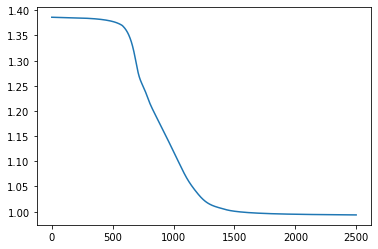

In [14]:
plt.plot(L_loss)
plt.show()

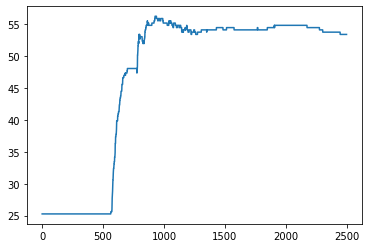

In [15]:
plt.plot(L_acc)
plt.show()

In [16]:
log_Xs = linalg.sym_logm(cov_Xs[:,:,freq].detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,:,freq].detach().cpu()).reshape(-1, d*d)

In [17]:
data = torch.cat([log_Xs, log_Xt], dim=0)

In [18]:
X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(data.numpy())

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


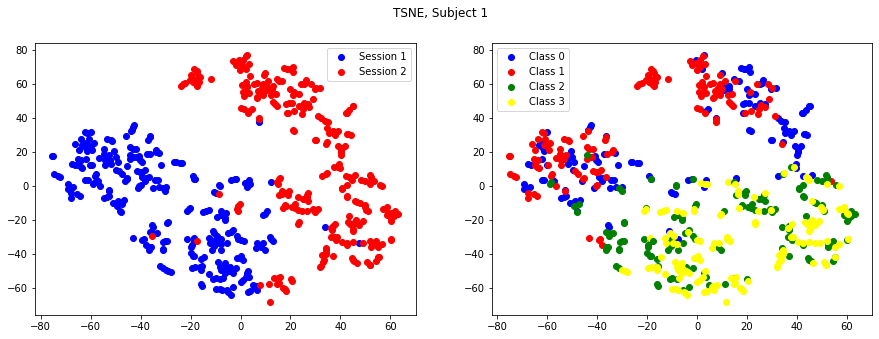

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

ax[0].legend()
ax[1].legend()

plt.suptitle("TSNE, Subject 1")
plt.show()

### Golden Score: Classifier on target

In [20]:
epochs = 1000
# num_projs = 500
d = 22
n_classes = 4
lr = 1e-1

freq = 0

criterion = nn.CrossEntropyLoss()

classifier = mlp_spd(d*d, 100, n_classes, 5).to(device)

# optimizer = MixOptimizer(list(classifier.parameters()), lr=lr)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

L_loss = []
L_acc = []

pbar = trange(epochs)

for e in pbar:    
    y_hat = classifier(cov_Xt[:,:,freq].type(torch.float32))
    classif_loss = criterion(y_hat, yt)
    
    loss = classif_loss
    loss.backward()
    
    L_loss.append(loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
#     pbar.set_postfix_str(f"loss = {loss.item():.3f} ")
#     print(loss.item(), align_loss.item(), classif_loss.item())

    with torch.no_grad():
        y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        
        L_acc.append(acc.item())
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"acc = {acc.item():.3f}")



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.27it/s, loss = 0.779 acc = 96.441]


In [21]:
y_test = classifier(cov_Xt[:,:,freq].type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 96.4412841796875%


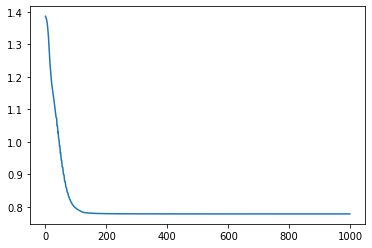

In [22]:
plt.plot(L_loss)
plt.show()

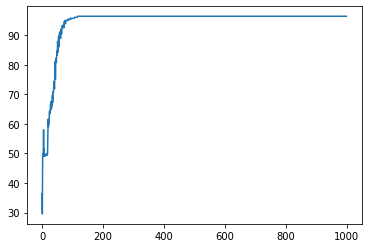

In [23]:
plt.plot(L_acc)
plt.show()

### Training

In [57]:
epochs = 5000
num_projs = 500
d = 22
n_classes = 4
lr = 1e-1

freq = 0

criterion = nn.CrossEntropyLoss()

model = SPDNet(d).to(device)
classifier = mlp_spd(d*d, 3, n_classes, 5).to(device)

# optimizer = MixOptimizer(list(model.parameters()) + list(classifier.parameters()), lr=lr)
optimizer = MixOptimizer(list(model.parameters()) + list(classifier.parameters()), lr=lr, lr_sgd=1)
#                          , momentum=0.9, weight_decay=5e-4)

L_loss = []
L_sw = []
L_classif = []
L_acc = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,freq])
    zt = model(cov_Xt[:,:,freq])
    
    y_hat = classifier(zs.type(torch.float32))
    
    align_loss = sliced_wasserstein_spd(zs[:,0], zt[:,0], num_projs, device, p=2)
    classif_loss = criterion(y_hat, ys)        
    
    if epochs>500:
        loss = align_loss + classif_loss
    else:
        loss = classif_loss
        
    loss.backward()
    
    L_loss.append(loss.item())
    L_sw.append(align_loss.item())
    L_classif.append(classif_loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
    with torch.no_grad():
        y_test = classifier(zt.type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        
        L_acc.append(acc.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"sw = {align_loss.item():.3f} " 
                         + f"bce = {classif_loss.item():.3f} " + f"acc = {acc.item():.3f}")
#     print(loss.item(), align_loss.item(), classif_loss.item())


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:13:25<00:00,  1.13it/s, loss = 0.745 sw = 0.001 bce = 0.744 acc = 76.157]


In [58]:
y_test = classifier(zt.type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 76.15658569335938%


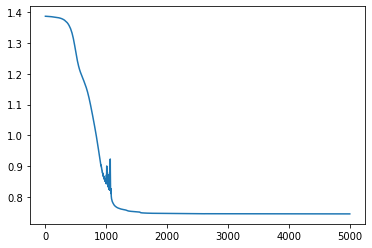

In [59]:
plt.plot(L_loss)
plt.show()

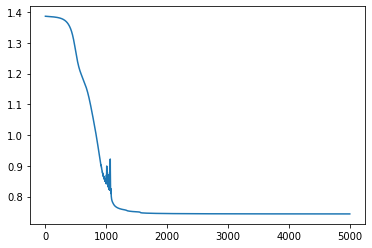

In [60]:
plt.plot(L_classif)
plt.show()

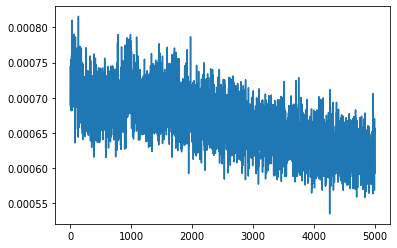

In [61]:
plt.plot(L_sw)
plt.show()

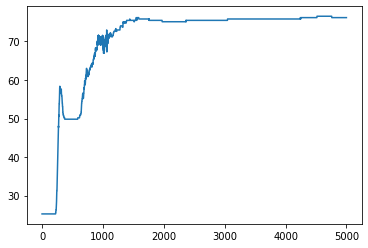

In [62]:
plt.plot(L_acc)
plt.show()

In [63]:
log_Xs = linalg.sym_logm(zs.detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(zt.detach().cpu()).reshape(-1, d*d)

data = torch.cat([log_Xs, log_Xt], dim=0)
X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(data.numpy())

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


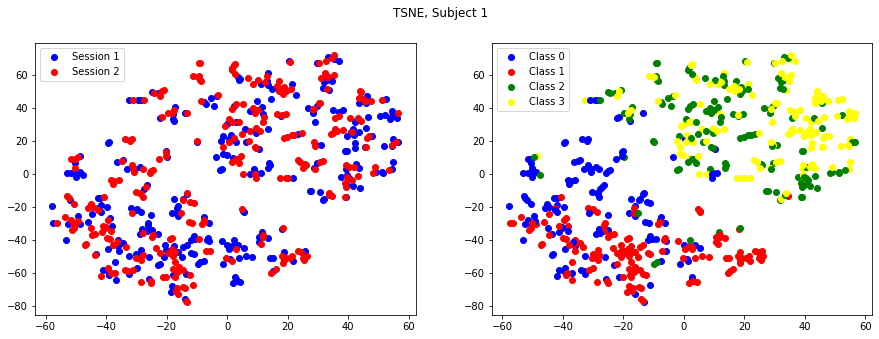

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

ax[0].legend()
ax[1].legend()

plt.suptitle("TSNE, Subject 1")
plt.show()

In [20]:
epochs = 5000
num_projs = 500
d = 22
n_classes = 4
lr = 1e-1

freq = 0

criterion = nn.CrossEntropyLoss()

model = SPDNet(d).to(device)
classifier = mlp_spd(d*d, 3, n_classes, 5).to(device)

# optimizer = MixOptimizer(list(model.parameters()) + list(classifier.parameters()), lr=lr)
optimizer = MixOptimizer(list(model.parameters()) + list(classifier.parameters()), lr=lr, lr_sgd=1)
#                          , momentum=0.9, weight_decay=5e-4)

L_loss = []
L_sw = []
L_classif = []
L_acc = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,freq])
    zt = model(cov_Xt[:,:,freq])
    
    y_hat = classifier(zs.type(torch.float32))
    
    align_loss = sliced_wasserstein_spd(zs[:,0], zt[:,0], num_projs, device, p=2)
    classif_loss = criterion(y_hat, ys)        
    
    if epochs>500:
        loss = align_loss + classif_loss
    else:
        loss = classif_loss
        
    loss.backward()
    
    L_loss.append(loss.item())
    L_sw.append(align_loss.item())
    L_classif.append(classif_loss.item())
    
    optimizer.step()
    optimizer.zero_grad()
    
    with torch.no_grad():
        y_test = classifier(zt.type(torch.float32))
        acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
        
        L_acc.append(acc.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f} " + f"sw = {align_loss.item():.3f} " 
                         + f"bce = {classif_loss.item():.3f} " + f"acc = {acc.item():.3f}")
#     print(loss.item(), align_loss.item(), classif_loss.item())


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:30:58<00:00,  1.09s/it, loss = 0.755 sw = 0.001 bce = 0.755 acc = 73.665]


In [21]:
y_test = classifier(zt.type(torch.float32))
acc = torch.sum(torch.argmax(y_test, dim=-1) == yt) * 100/len(yt)
print("Accuracy = " + str(acc.item()) + "%")

Accuracy = 73.66548156738281%


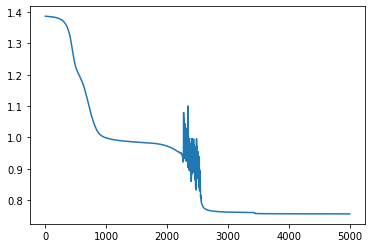

In [22]:
plt.plot(L_loss)
plt.show()

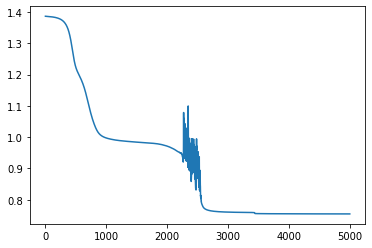

In [23]:
plt.plot(L_classif)
plt.show()

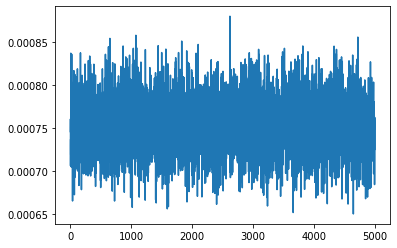

In [24]:
plt.plot(L_sw)
plt.show()

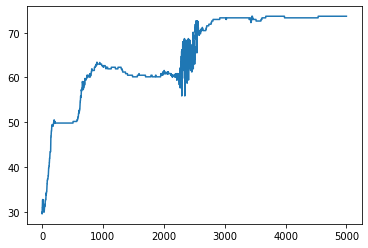

In [25]:
plt.plot(L_acc)
plt.show()

In [26]:
log_Xs = linalg.sym_logm(zs.detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(zt.detach().cpu()).reshape(-1, d*d)

data = torch.cat([log_Xs, log_Xt], dim=0)
X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(data.numpy())

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


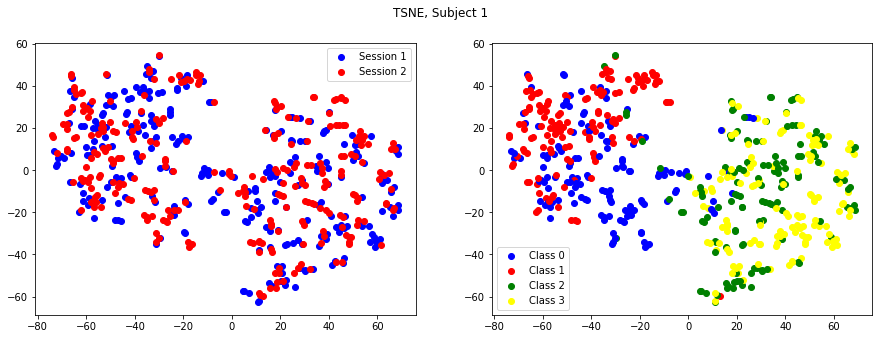

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

ax[0].legend()
ax[1].legend()

plt.suptitle("TSNE, Subject 1")
plt.show()